In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [8]:
data_dir = 'data'

In [9]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_train)
class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [12]:
# Stratified Split
targets = np.array(full_dataset.targets)
train_idx, val_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

In [13]:
# Apply different transforms for train/val
train_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=transform_train), train_idx)
val_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=transform_val), val_idx)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [15]:
# Handle Class Imbalance
class_weights = compute_class_weight("balanced", classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis("off")

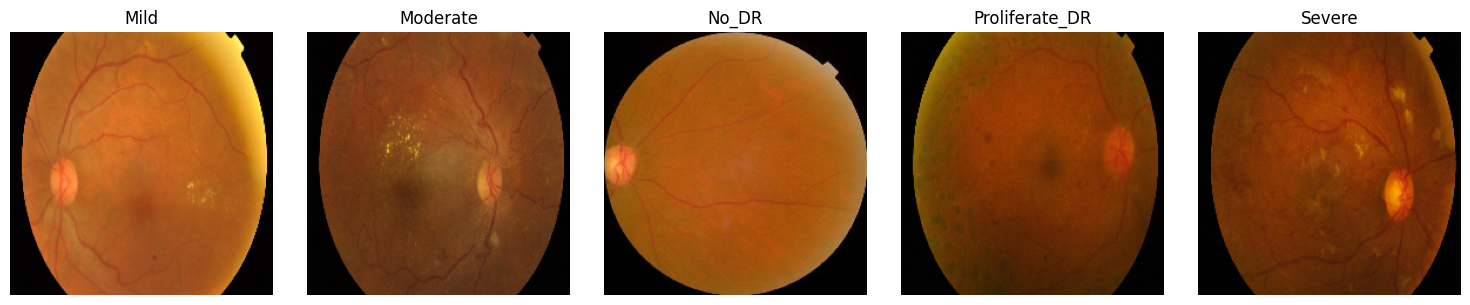

In [20]:
import os, random
valid_exts = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}

sample_images = []
sample_labels = []
for cls in class_names:
    cls_dir = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_dir):
        continue
    files = [f for f in os.listdir(cls_dir) if os.path.splitext(f)[1].lower() in valid_exts]
    if not files:
        continue
    img_path = os.path.join(cls_dir, random.choice(files))
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform_val(img)
    sample_images.append(img_tensor)
    sample_labels.append(cls)

if sample_images:
    cols = len(sample_images)
    plt.figure(figsize=(3 * cols, 3))
    for i, (img_t, label) in enumerate(zip(sample_images, sample_labels), start=1):
        ax = plt.subplot(1, cols, i)
        plt.sca(ax)
        imshow(img_t, title=label)
    plt.tight_layout()
    plt.show()
else:
    print("No images found to display. Check your data directories and file extensions.")

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(class_names))  # 5 classes
model = model.to(device)

In [22]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3)

In [ ]:
num_epochs = 5
patience = 2  # early stopping
best_val_loss = np.inf
early_stop_counter = 0

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Update scheduler
    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

In [ ]:
# Evaluation 
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

In [ ]:
# Plot Training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()

plt.show()